# 연예인 닮은 꼴 찾기
- 사진속 얼굴 좌표를 찾습니다.
  - FaceNet를 활용하여 사진속 얼굴 영역을 찾습니다.
- 얼굴 영역만 crop해서 embedding을 진행합니다.
- embedding된 값을 활용하여 다른 이미지속 얼굴과 비교하여 거리를 측정합니다.

## 1. Import module

In [1]:
import os
import face_recognition
import numpy as np
from PIL import Image

dir_path = './data'
file_list = os.listdir(dir_path)
print ("file_list: {}".format(file_list))
import matplotlib.pyplot as plt
import matplotlib.image as img


file_list: ['1.jpg', '2.jpg', 'BUMZU.jpg', 'euPhemia.jpg', 'G-DRAGON.jpg', 'JK김동욱.jpg', 'K.WILL.jpg', 'KCM.jpg', 'MC몽.jpg', 'RM.jpg', 'SE7EN.jpg', 'T.O.P.jpg', 'V.One.jpg', 'Zion.T.jpg', '가희.jpg', '간미연.jpg', '갈소원.jpg', '감우성.jpg', '강경준.jpg', '강경헌.jpg', '강균성.jpg', '강기영.jpg', '강남길.jpg', '강다현.jpg', '강동원.jpg', '강두리.jpg', '강리나.jpg', '강문경.jpg', '강문영.jpg', '강민경.jpg', '강민아.jpg', '강민주.jpg', '강별.jpg', '강봉성.jpg', '강부자.jpg', '강산에.jpg', '강석우.jpg', '강성민.jpg', '강성아.jpg', '강성연.jpg', '강성진.jpg', '강성필.jpg', '강소라.jpg', '강소리.jpg', '강소연.jpg', '강수연.jpg', '강수지.jpg', '강수진.jpg', '강승원.jpg', '강승윤.jpg', '강신일.jpg', '강예빈.jpg', '강예솔.jpg', '강예원.jpg', '강은비.jpg', '강은탁.jpg', '강이석.jpg', '강이채.jpg', '강인덕.jpg', '강인봉.jpg', '강정우.jpg', '강지섭.jpg', '강지환.jpg', '강진.jpg', '강타.jpg', '강태오.jpg', '강하늘.jpg', '강한나.jpg', '강혜연.jpg', '개리.jpg', '거미.jpg', '건지.jpg', '견미리.jpg', '견우.jpg', '경수진.jpg', '경인선.jpg', '고경표.jpg', '고나은.jpg', '고나희.jpg', '고두심.jpg', '고민시.jpg', '고보결.jpg', '고성희.jpg', '고세원.jpg', '고소영.jpg', '고수.jpg', '고아라.jpg', '고아성.jpg', '고운봉.jpg

## 2. Crop Face location
- FaceNet을 활용하여 이미지속 얼굴이 포함되는 좌표를 찾아 return합니다.
  - 사진속 얼굴 영역을 찾지 못한 경우는 예외를 발생시켜 return합니다.

In [3]:
def get_cropped_face(image_file):        
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
#     print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.
    if not face_locations:
        cropped_face = image[0:1,0:1,:]        
        return cropped_face
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]    
    
    return cropped_face

### Example
- 제 사진을 가지고 화면에 출력합니다.

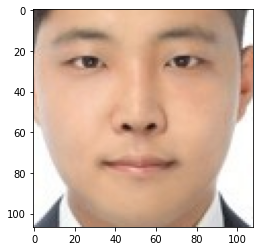

In [7]:
example_img = './my/1.jpg'

cropped_face = get_cropped_face(example_img)
plt.imshow(cropped_face)

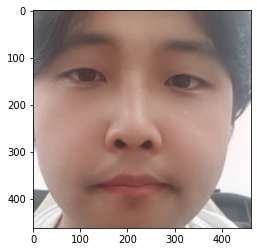

In [8]:
example_img2 = './my/2.jpg'

cropped_face2 = get_cropped_face(example_img2)
plt.imshow(cropped_face2)

## Face embedding
- crop된 얼굴 이미지를 embedding합니다.

In [4]:
import os
file_list = os.listdir(dir_path)

# print ("file_list: {}".format(file_list))
image_file_ = os.path.join('./my', '1.jpg')
face = get_cropped_face(image_file_)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):  
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
# embedding


## Face embedding dict
- embedding한 값들을 dict에 넣어 보관합니다.
- crop face에서 찾지 못한 얼굴 영역은 모양이 (1,1,3)으로 return을 하게 해주어 이번 함수에서는 다음과 같은 shape면 continue합니다.

In [5]:
def get_face_embedding_dict(dir_path_):
    file_list_ = os.listdir(dir_path_)
    embedding_dict = {}
    
    for file in file_list_:        
        img_path = os.path.join(dir_path_, file)        
        im = Image.open(img_path)
        face = get_cropped_face(img_path)
        if face.shape == (1,1,3):
            continue
        
        embedding = get_face_embedding(face)        
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [6]:
embedding_dict = get_face_embedding_dict(dir_path)

## Get distacne
- 사진들과의 embedding 거리를 측정합니다.

In [12]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('1', '2')

0.36773790558246733

## Get nearst face
- 1번 제사진을 기준으로 가장 가까운 사진 top 5를 찾습니다.

In [13]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('1')   

In [14]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [15]:
get_nearest_face('1')

순위 1 : 이름(2), 거리(0.36773790558246733)
순위 2 : 이름(온주완), 거리(0.3738880191234966)
순위 3 : 이름(장근석), 거리(0.3826861286535892)
순위 4 : 이름(최권수), 거리(0.38390776751201067)
순위 5 : 이름(심신), 거리(0.39186761848512114)
